# HOME CREDIT DEFAULT RISK

#

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import ADASYN

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
train_df = pd.read_csv("/content/application_train.csv")

In [3]:
print('Training Data Shape:', train_df.shape)

Training Data Shape: (307511, 122)


In [4]:
train_df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [5]:
train_df = train_df.drop('SK_ID_CURR', axis=1)

In [6]:
train_df.replace('XNA', np.nan, inplace=True)

##  Handling Missing Values

In [7]:
# Missing Values
missing_values = train_df.isnull().sum()
percentage_missing_values = (missing_values / len(train_df)) * 100
missing_columns = percentage_missing_values[percentage_missing_values > 0].sort_values()
columns_to_drop = percentage_missing_values[percentage_missing_values > 50].index
train_df = train_df.drop(columns=columns_to_drop)
train_df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 80 columns]

In [8]:
columns = percentage_missing_values[(30 < percentage_missing_values) & (percentage_missing_values < 50)].index
print("Columns with missing values between 30% and 50%:")
print(columns)

Columns with missing values between 30% and 50%:
Index(['OCCUPATION_TYPE', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')


In [9]:
columns_to_drop = ['YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI']
train_df = train_df.drop(columns=columns_to_drop)

## Exploratory Data Analysis

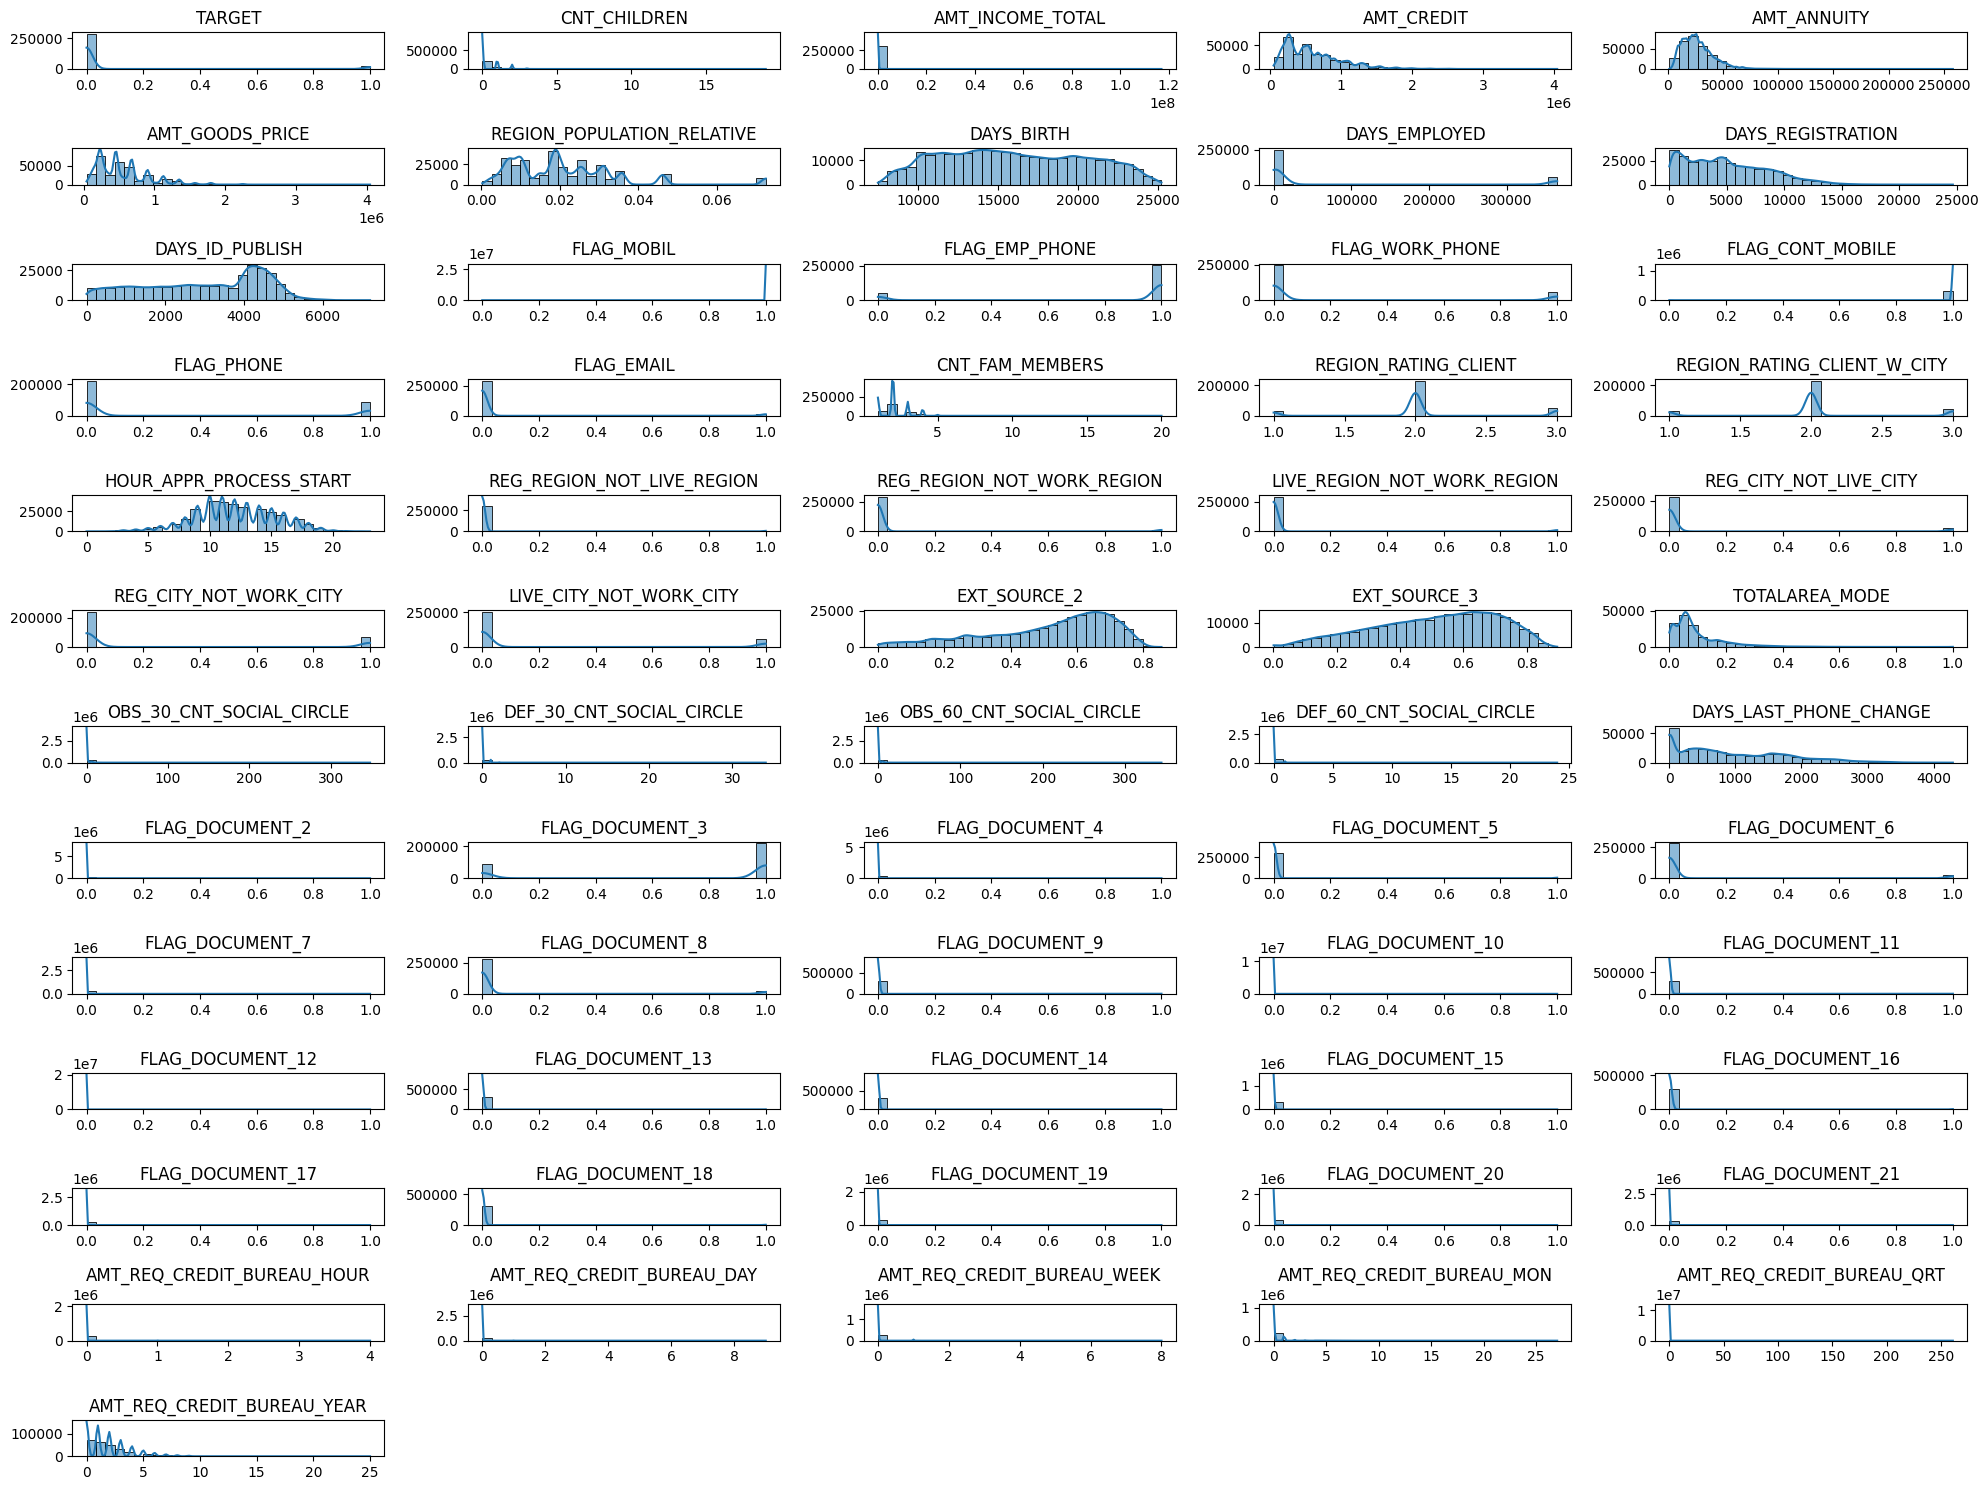

In [10]:
# Select numerical features
num_features = train_df.select_dtypes(include=['float64', 'int64']).columns
for col in num_features:
        train_df[col] = train_df[col].abs()

# Set the size of the plots
plt.figure(figsize=(20, 15))

# Loop through the numerical features and plot histograms
for i, feature in enumerate(num_features):
    plt.subplot((len(num_features) // 5) + 1, 5, i + 1)
    sns.histplot(train_df[feature], bins=30, kde=True)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

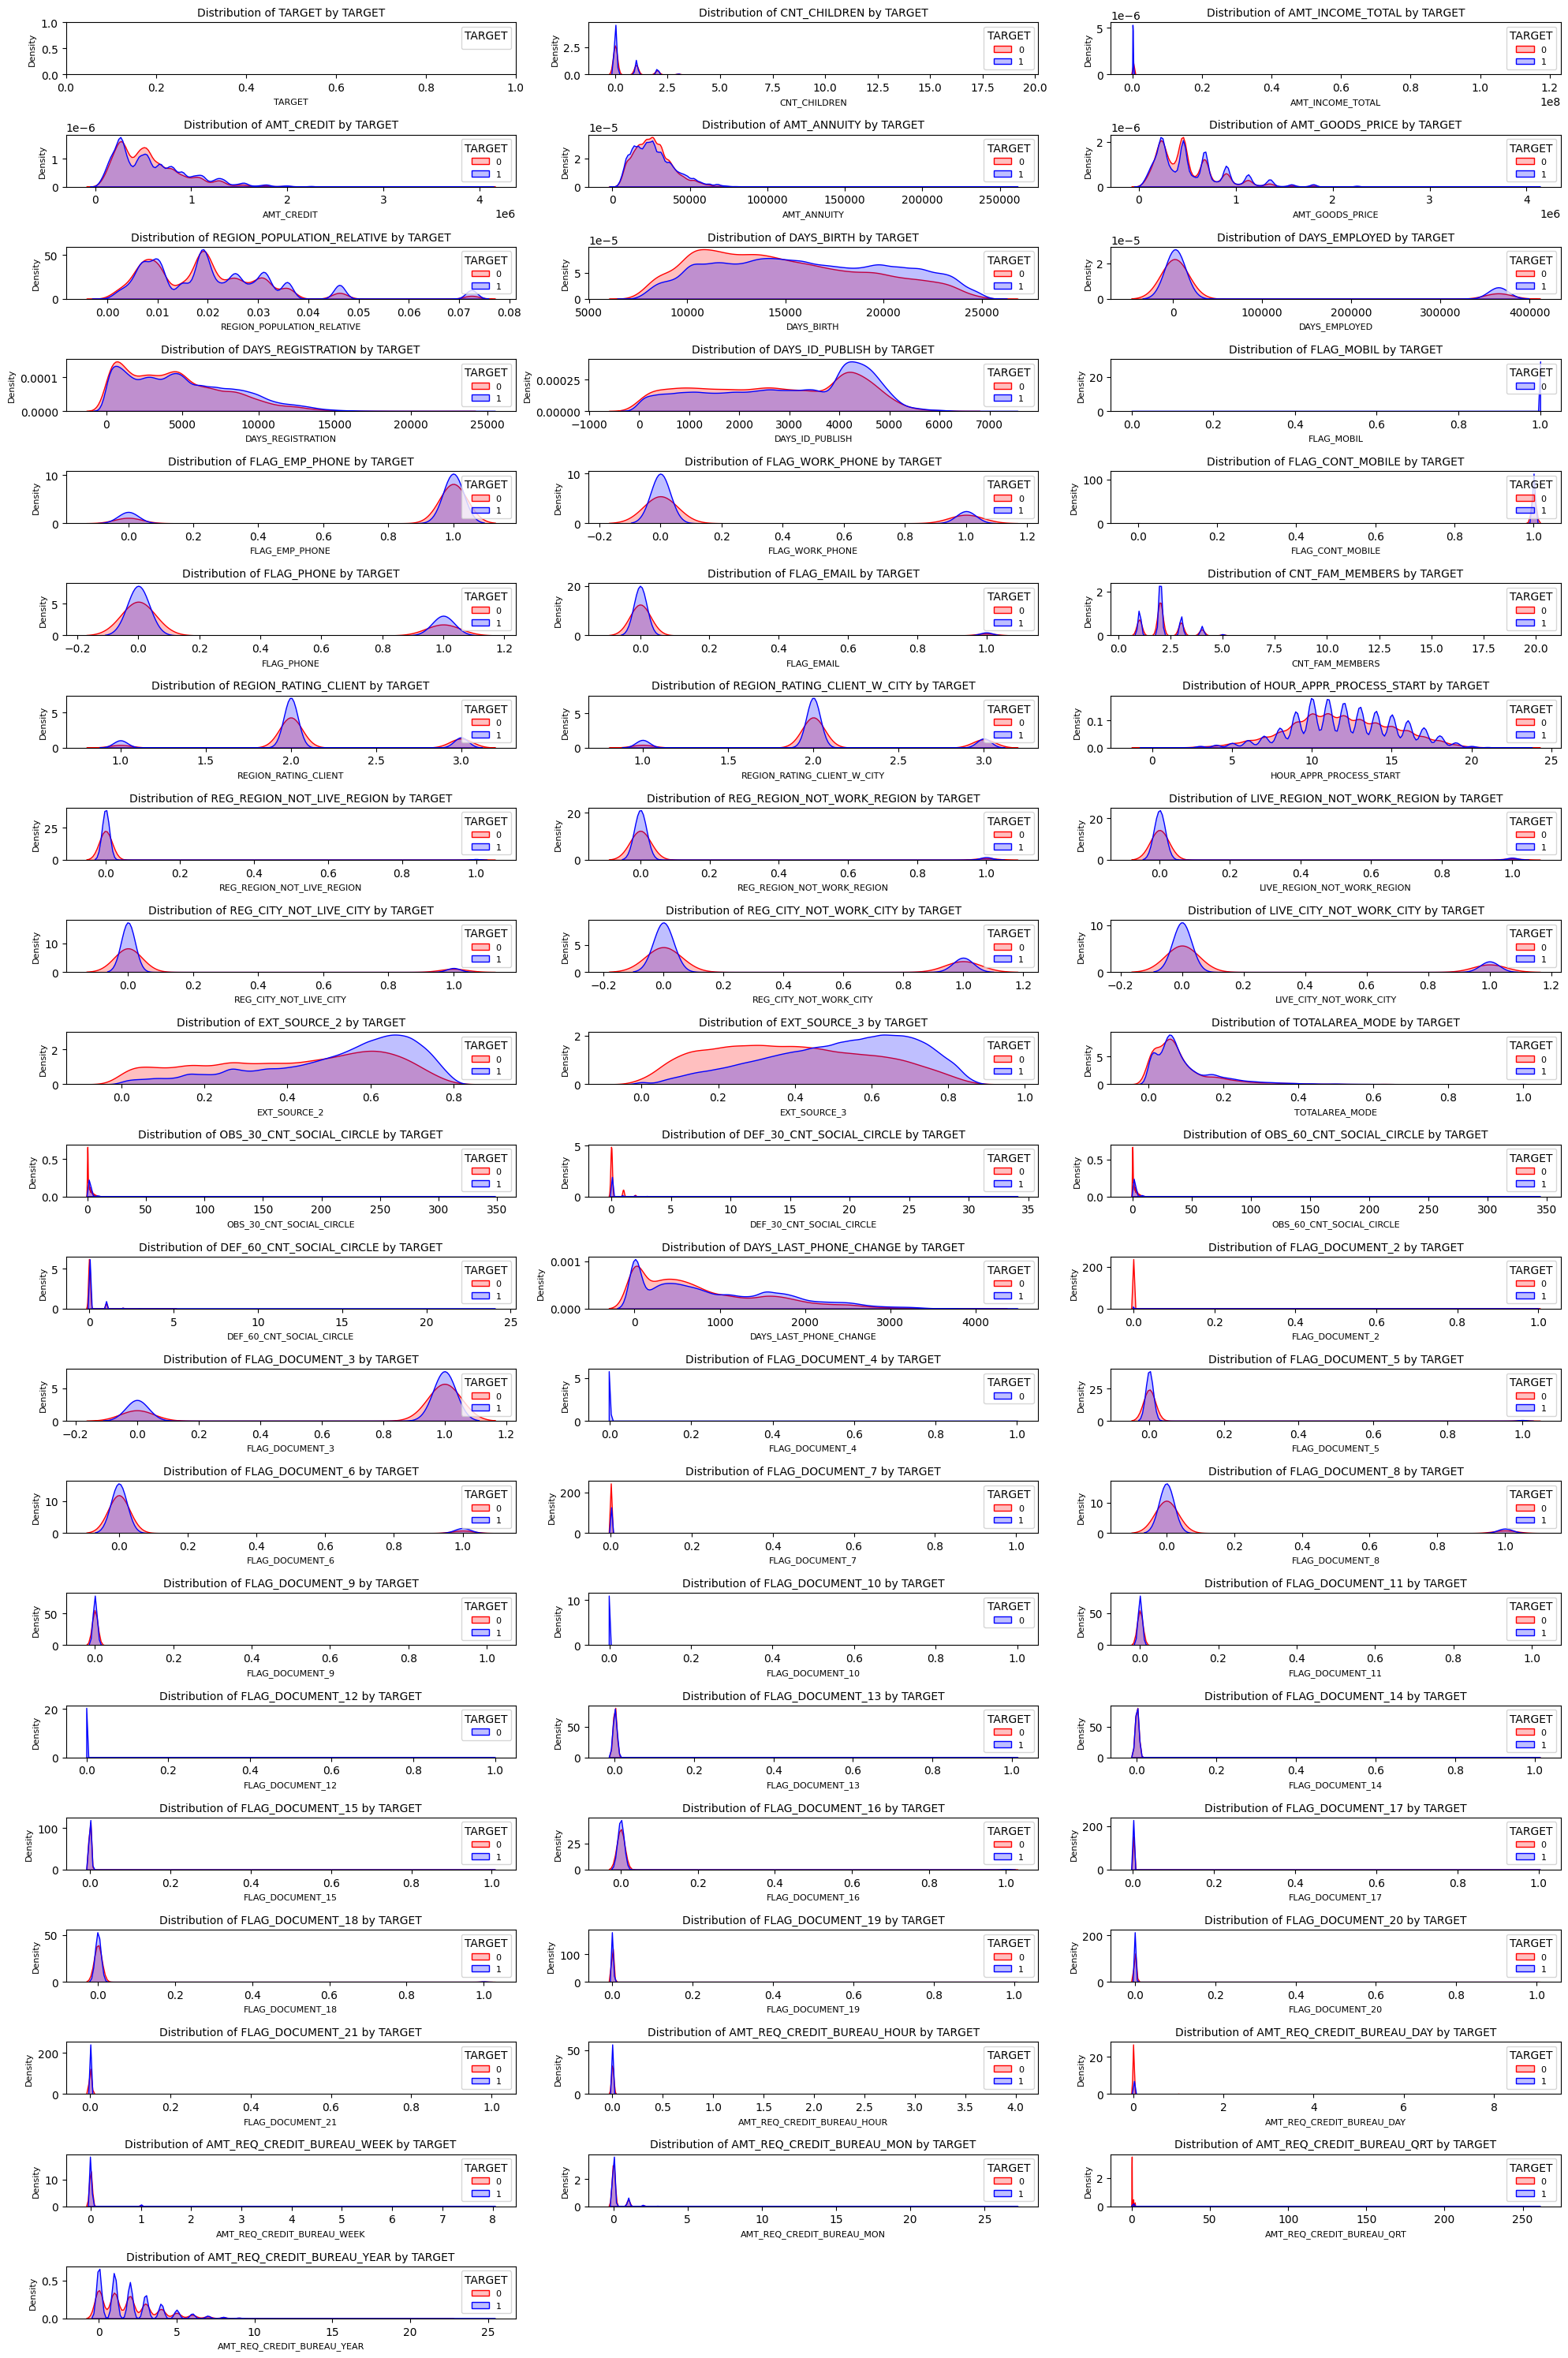

In [11]:
# Number of plots
n_plots = len(num_features)

# Calculate the number of rows and columns for the grid
n_cols = 3
n_rows = n_plots // n_cols + (n_plots % n_cols > 0)

# Set the size of the plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))

# Flatten the axes array for easier iteration
axes = axes.flatten()

palette = {0: 'blue', 1: 'red'}

# Loop through the numerical features and plot KDE plots
for i, col in enumerate(num_features):
    sns.kdeplot(data=train_df, x=col, hue='TARGET', palette=palette, common_norm=False, fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by TARGET', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Density', fontsize=8)
    axes[i].legend(title='TARGET', labels=['0', '1'], fontsize=8)

# Remove any unused axes in the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

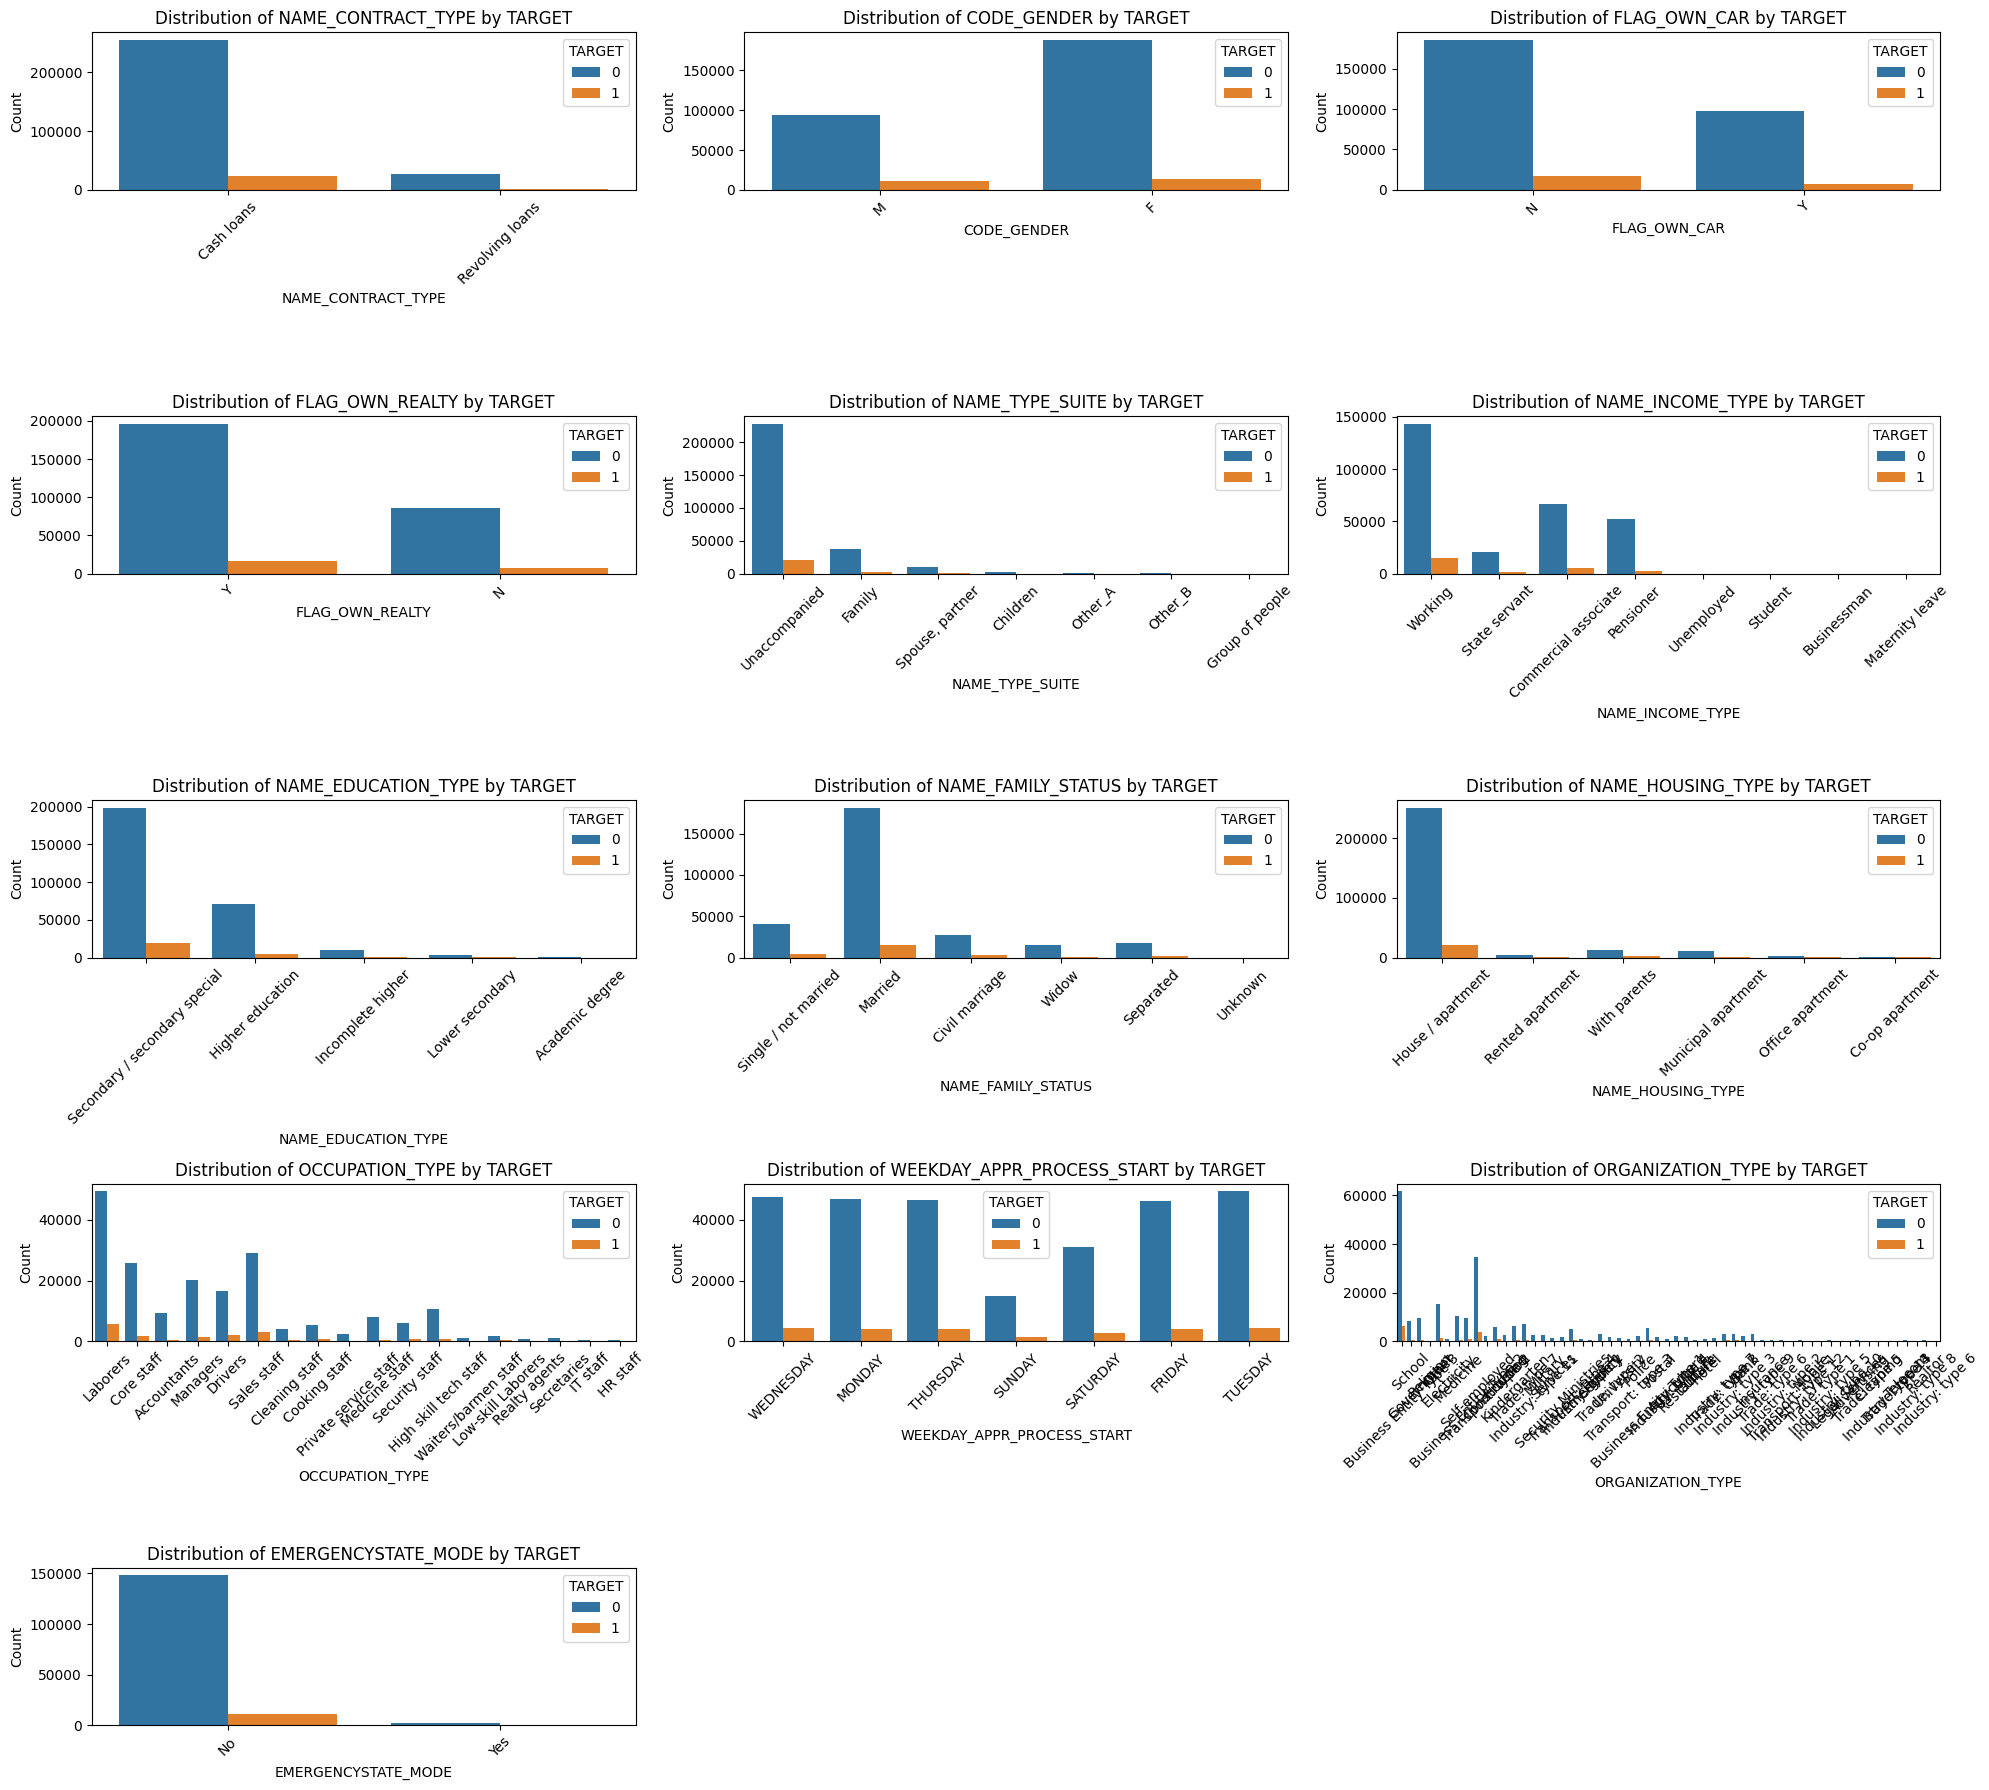

In [12]:
# List of categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Number of plots
n_plots = len(categorical_cols)

# Calculate the number of rows and columns for the grid
n_cols = 3
n_rows = n_plots // n_cols + (n_plots % n_cols > 0)

# Set the size of the plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the categorical features and plot count plots
for i, col in enumerate(categorical_cols):
    sns.countplot(data=train_df, x=col, hue='TARGET', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by TARGET')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='TARGET', labels=['0', '1'])
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused axes in the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# Summary statistics for numerical variables grouped by TARGET
numerical_summary = train_df.groupby('TARGET')[num_features].describe()
print(numerical_summary)

          TARGET                                    CNT_CHILDREN            \
           count mean  std  min  25%  50%  75%  max        count      mean   
TARGET                                                                       
0       282686.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     282686.0  0.412946   
1        24825.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0      24825.0  0.463807   

        ... AMT_REQ_CREDIT_BUREAU_QRT        AMT_REQ_CREDIT_BUREAU_YEAR  \
        ...                       75%    max                      count   
TARGET  ...                                                               
0       ...                       0.0  261.0                   245459.0   
1       ...                       0.0   19.0                    20533.0   

                                                      
            mean       std  min  25%  50%  75%   max  
TARGET                                                
0       1.889199  1.863376  0.0  0.0  1.0  3.0  25.0  
1       2.028

In [14]:
# Step 1: Convert DAYS_BIRTH to Age in Years
train_df['AGE'] = (train_df['DAYS_BIRTH'] / 365).astype(int)

# Step 2: Create Age Bins
bins = [18, 25, 35, 45, 55, 65, 75, 85]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
train_df['AGE_BIN'] = pd.cut(train_df['AGE'], bins=bins, labels=labels, right=False)

# Check the resulting DataFrame
print(train_df[['DAYS_BIRTH', 'AGE', 'AGE_BIN']].head())

train_df = train_df.drop('DAYS_BIRTH', axis=1)

   DAYS_BIRTH  AGE AGE_BIN
0        9461   25   26-35
1       16765   45   46-55
2       19046   52   46-55
3       19005   52   46-55
4       19932   54   46-55


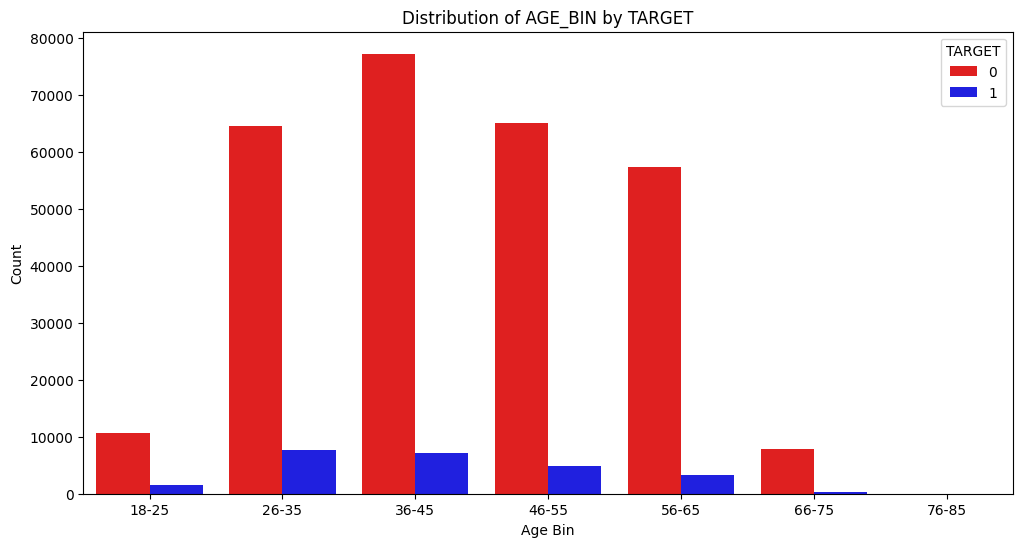

In [15]:
# Visualize the distribution of AGE_BIN using a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='AGE_BIN', hue='TARGET', palette={0: 'red', 1: 'blue'})
plt.title('Distribution of AGE_BIN by TARGET')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.legend(title='TARGET', labels=['0', '1'])
plt.show()

In [16]:
import numpy as np

# Define a reasonable threshold
threshold = 18250  # Example threshold (50 years)

# Cap the anomalies at the threshold
train_df['DAYS_EMPLOYED'] = np.where(train_df['DAYS_EMPLOYED'] > threshold, threshold, train_df['DAYS_EMPLOYED'])

# Create a flag for anomalies
train_df['ANOMALY_FLAG'] = train_df['DAYS_EMPLOYED'] > threshold

# Verify the changes
print(train_df['DAYS_EMPLOYED'].describe())
print(train_df[['DAYS_EMPLOYED', 'ANOMALY_FLAG']].head())

count    307511.000000
mean       5241.154954
std        6453.643206
min           0.000000
25%         933.000000
50%        2219.000000
75%        5707.000000
max       18250.000000
Name: DAYS_EMPLOYED, dtype: float64
   DAYS_EMPLOYED  ANOMALY_FLAG
0            637         False
1           1188         False
2            225         False
3           3039         False
4           3038         False


In [17]:
# Step 1: Convert DAYS_EMPLOYED to EMPLOYMENT_YEARS in Years
train_df['EMPLOYMENT_YEARS'] = (train_df['DAYS_EMPLOYED'] / 365).astype(int)

# Step 2: Create Age Bins
bins = [0,3,6,9,12,15,20,25,30,40,50,60,70, float('inf')]
labels = ['0-3','4-6', '7-9', '10-12', '13-15', '16-20', '21-25', '26-30', '31-40', '41-50', '51-60', '61+', '71+']
train_df['EMPLOYMENT_YEARS_BIN'] = pd.cut(train_df['EMPLOYMENT_YEARS'], bins=bins, labels=labels, right=False)

# Check the resulting DataFrame
print(train_df[['DAYS_EMPLOYED', 'EMPLOYMENT_YEARS', 'EMPLOYMENT_YEARS_BIN']].head())

train_df = train_df.drop('DAYS_EMPLOYED', axis=1)

   DAYS_EMPLOYED  EMPLOYMENT_YEARS EMPLOYMENT_YEARS_BIN
0            637                 1                  0-3
1           1188                 3                  4-6
2            225                 0                  0-3
3           3039                 8                  7-9
4           3038                 8                  7-9


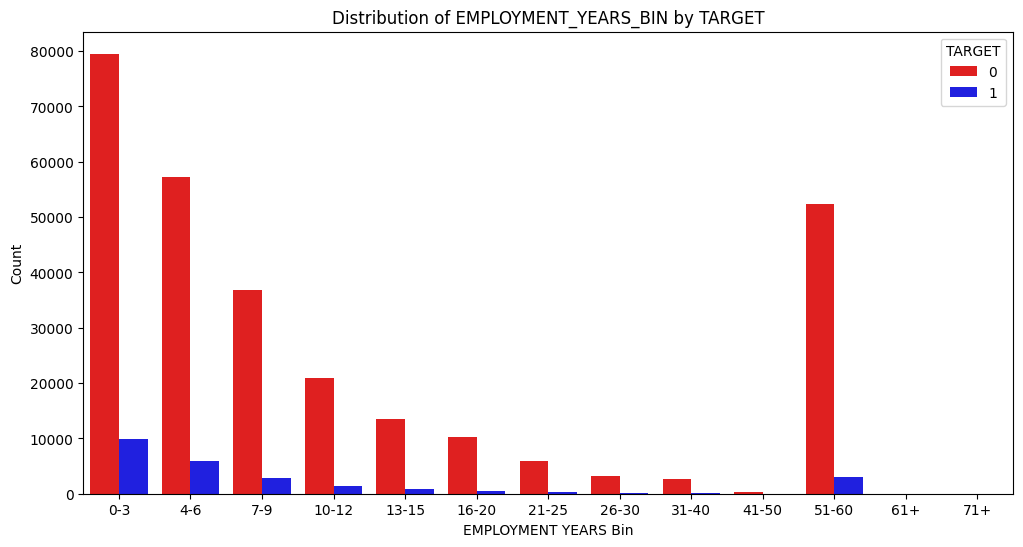

In [18]:
# Visualize the distribution of AGE_BIN using a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='EMPLOYMENT_YEARS_BIN', hue='TARGET', palette={0: 'red', 1: 'blue'})
plt.title('Distribution of EMPLOYMENT_YEARS_BIN by TARGET')
plt.xlabel('EMPLOYMENT YEARS Bin')
plt.ylabel('Count')
plt.legend(title='TARGET', labels=['0', '1'])
plt.show()

In [19]:
Missing_Values_Columns = train_df.isnull().sum()[train_df.isnull().sum()>0].sort_values()
print(Missing_Values_Columns)

DAYS_LAST_PHONE_CHANGE             1
CNT_FAM_MEMBERS                    2
CODE_GENDER                        4
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
EXT_SOURCE_2                     660
OBS_30_CNT_SOCIAL_CIRCLE        1021
DEF_30_CNT_SOCIAL_CIRCLE        1021
OBS_60_CNT_SOCIAL_CIRCLE        1021
DEF_60_CNT_SOCIAL_CIRCLE        1021
NAME_TYPE_SUITE                 1292
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_HOUR     41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
ORGANIZATION_TYPE              55374
EXT_SOURCE_3                   60965
OCCUPATION_TYPE                96391
EMERGENCYSTATE_MODE           145755
TOTALAREA_MODE                148431
dtype: int64


In [20]:
# Imputing missing values with zero for specific columns
cols_to_impute_with_zero = [
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

for col in cols_to_impute_with_zero:
    train_df[col].fillna(0, inplace=True)

# Imputing missing values with median for specific columns
cols_to_impute_with_median = [
    'DAYS_LAST_PHONE_CHANGE',
    'CNT_FAM_MEMBERS',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE'
]

for col in cols_to_impute_with_median:
    train_df[col].fillna(train_df[col].median(), inplace=True)

# Imputing missing values with mean for specific columns
cols_to_impute_with_mean = [
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'TOTALAREA_MODE'
]

for col in cols_to_impute_with_mean:
    train_df[col].fillna(train_df[col].mean(), inplace=True)

cols_to_impute_with_mode = [
    'OCCUPATION_TYPE',
    'EMERGENCYSTATE_MODE'
]

for col in cols_to_impute_with_mode:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

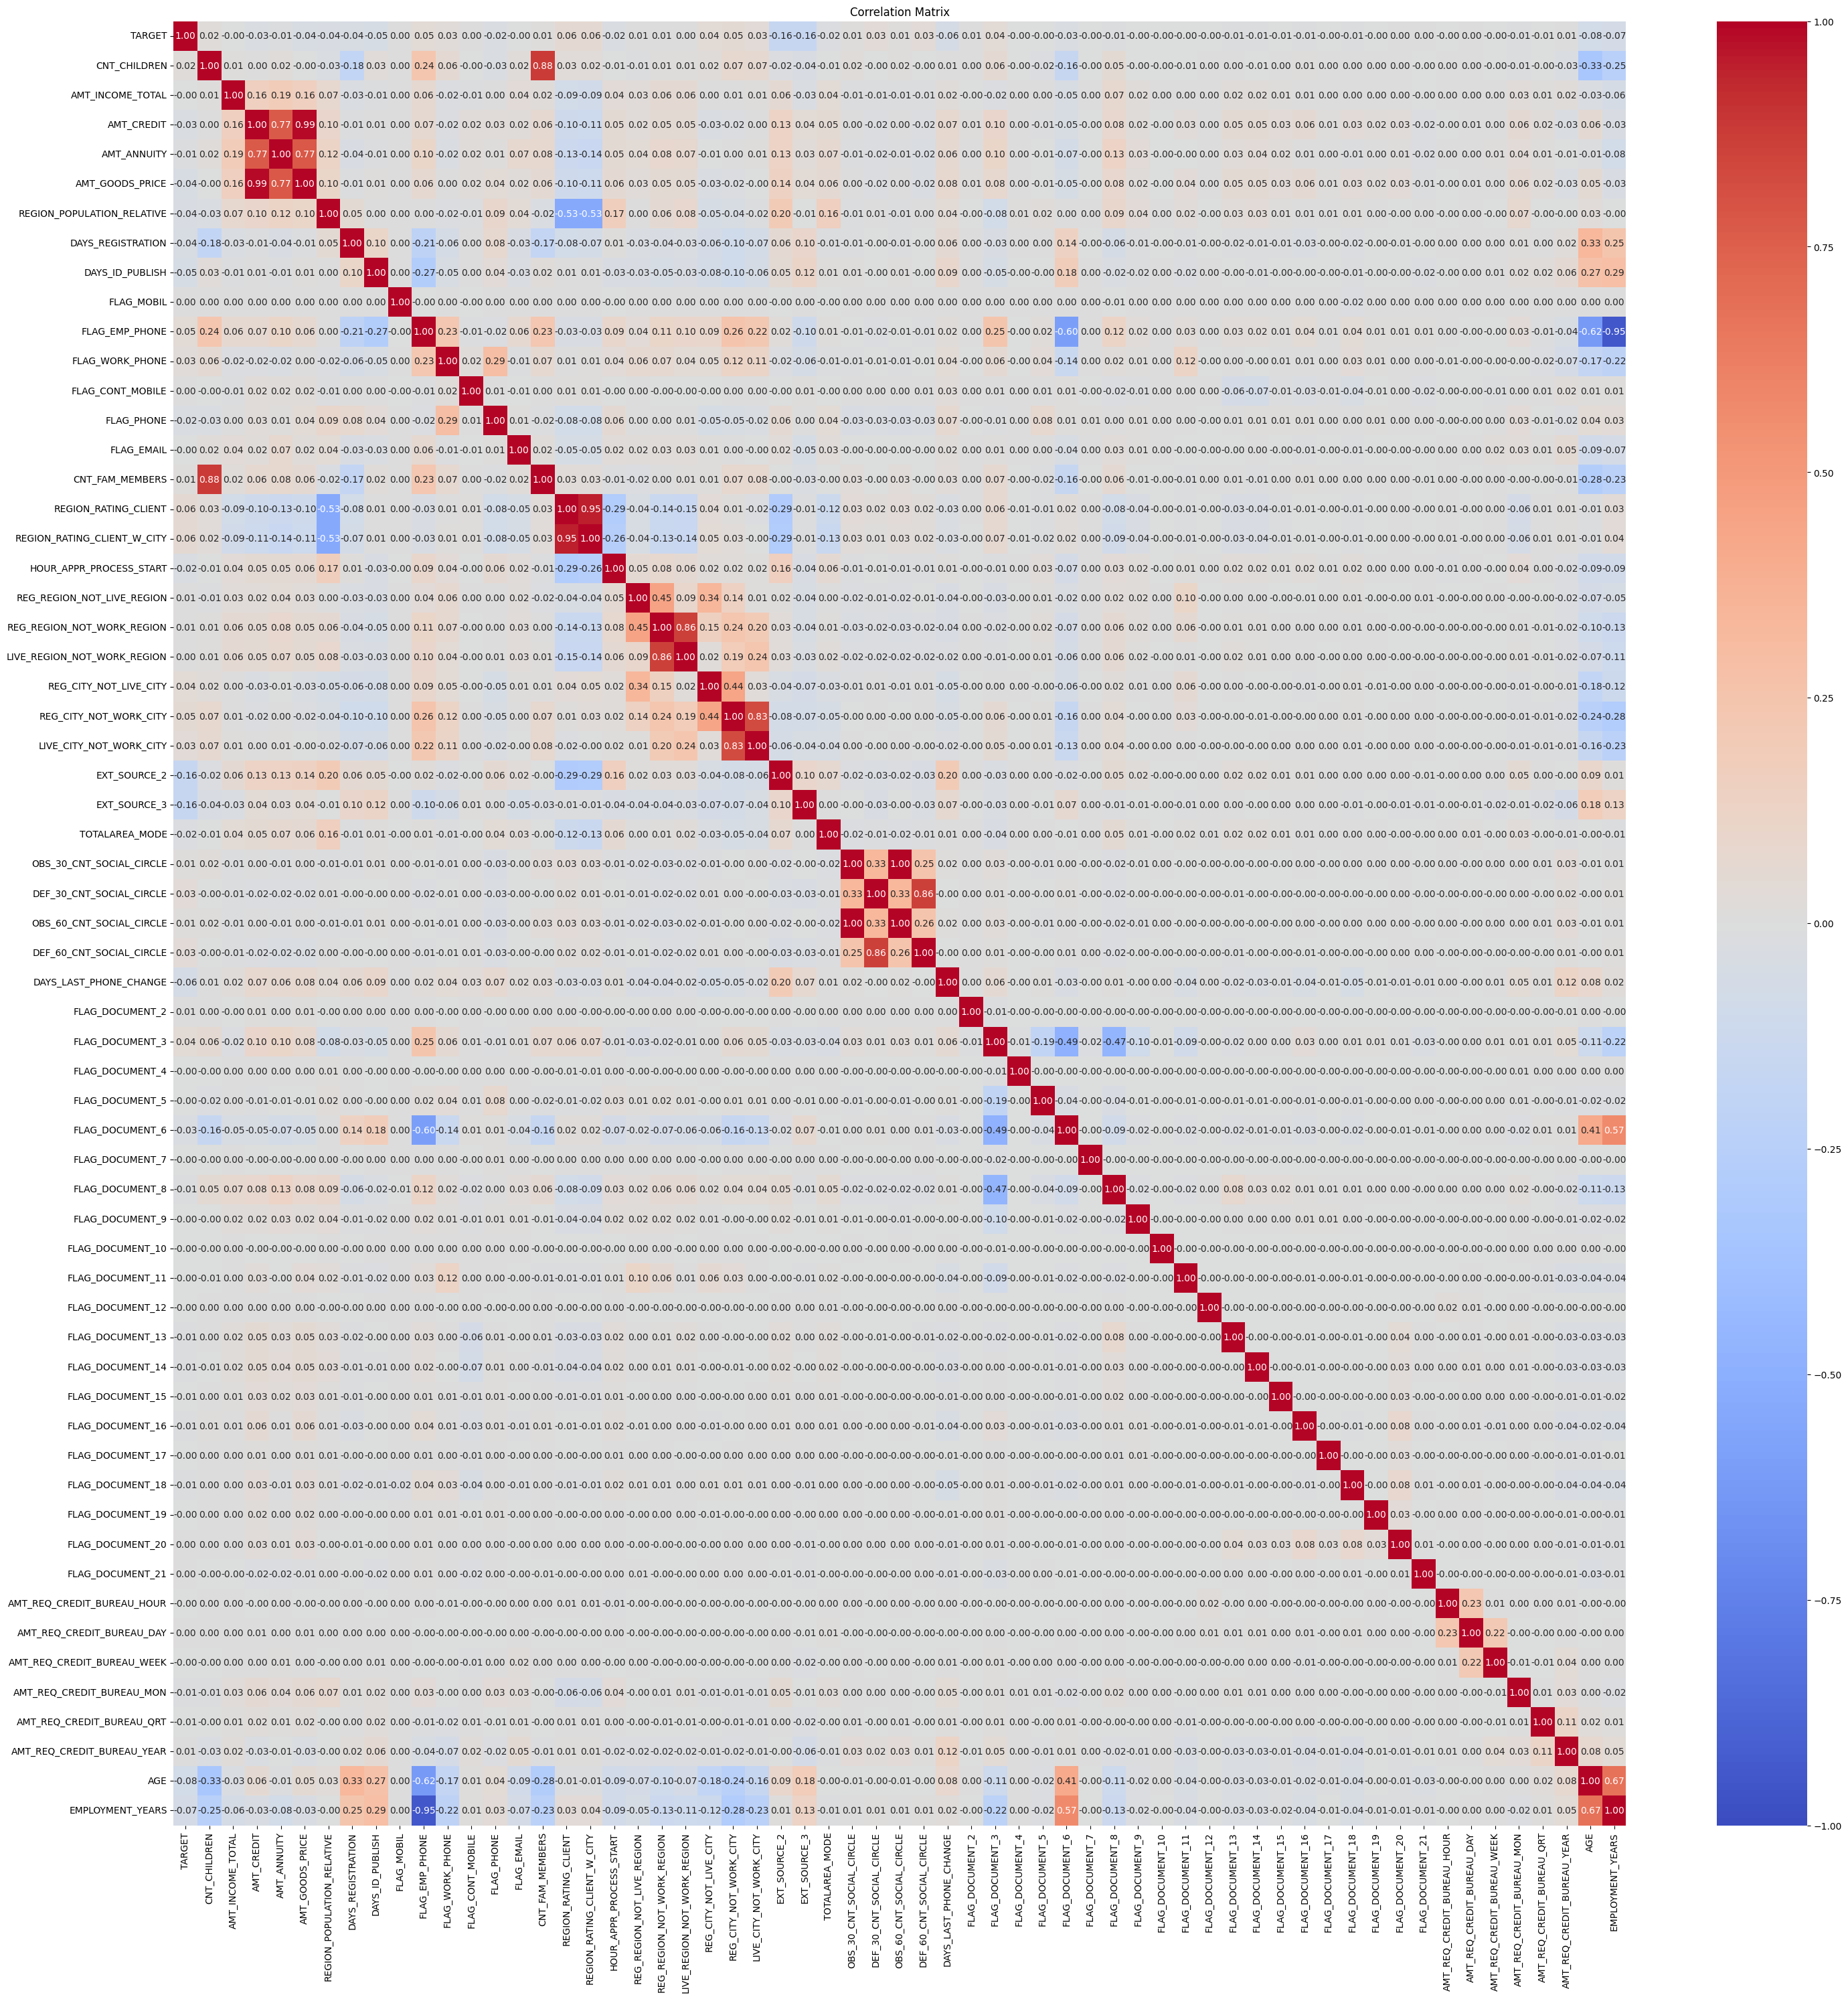

In [21]:
# Correlation matrix
num_features = train_df.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = train_df[num_features].corr()
plt.figure(figsize=(35, 35))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Encoding categorical variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    if train_df[col].nunique() == 2:
        train_df[col] = label_encoder.fit_transform(train_df[col])
    else:
        train_df = pd.get_dummies(train_df, columns=[col])

In [23]:
print(train_df.dtypes)

TARGET                                 int64
NAME_CONTRACT_TYPE                     int64
CODE_GENDER                            int64
FLAG_OWN_CAR                           int64
FLAG_OWN_REALTY                        int64
                                       ...  
ORGANIZATION_TYPE_Transport: type 1     bool
ORGANIZATION_TYPE_Transport: type 2     bool
ORGANIZATION_TYPE_Transport: type 3     bool
ORGANIZATION_TYPE_Transport: type 4     bool
ORGANIZATION_TYPE_University            bool
Length: 183, dtype: object


In [24]:
# Convert boolean columns to integers
boolean_cols = train_df.select_dtypes(include=['bool']).columns
train_df[boolean_cols] = train_df[boolean_cols].astype(int)


In [25]:
df = train_df.copy()

In [26]:
df = pd.get_dummies(df, columns=['AGE_BIN', 'EMPLOYMENT_YEARS_BIN'])

In [27]:
# Separate the features and the target
X_df = df.drop('TARGET', axis=1)
y_df = df['TARGET']

In [28]:
# Apply ADASYN to balance the classes
over_sample = ADASYN(random_state=42)
X, y = over_sample.fit_resample(X_df, y_df)

In [29]:
# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Define parameter grid
param_grid = {
    'reg_alpha': [0, 0.01, 0.1, 0.5, 0.75, 1],
    'reg_lambda': [0, 0.01, 0.1, 0.5, 0.75, 1],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state =42)

# Initialize GridSearchCV
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

xgb = random_search.best_estimator_

xgb.fit(X_train, y_train)
train_accuracy = xgb.score(X_train, y_train)
test_accuracy = xgb.score(X_test, y_test)
print(f'XGBoost - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}')




Best parameters found: {'reg_lambda': 0.5, 'reg_alpha': 0.75, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}
XGBoost - Train Accuracy: 0.96, Test Accuracy: 0.96


In [32]:
# Get feature importances from XGBoost
xgb_importances = xgb.feature_importances_


# Create a DataFrame for better handling and visualization
importance_df = pd.DataFrame({
    'feature': X_df.columns,
    'importance': xgb_importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Display the top features
print(importance_df.head(10))

                                   feature  importance
187               EMPLOYMENT_YEARS_BIN_0-3    0.056993
76              NAME_INCOME_TYPE_Pensioner    0.044097
116      WEEKDAY_APPR_PROCESS_START_FRIDAY    0.043661
83   NAME_EDUCATION_TYPE_Incomplete higher    0.042495
118    WEEKDAY_APPR_PROCESS_START_SATURDAY    0.038214
77          NAME_INCOME_TYPE_State servant    0.038175
86       NAME_FAMILY_STATUS_Civil marriage    0.038172
117      WEEKDAY_APPR_PROCESS_START_MONDAY    0.034694
188               EMPLOYMENT_YEARS_BIN_4-6    0.034591
122   WEEKDAY_APPR_PROCESS_START_WEDNESDAY    0.034102


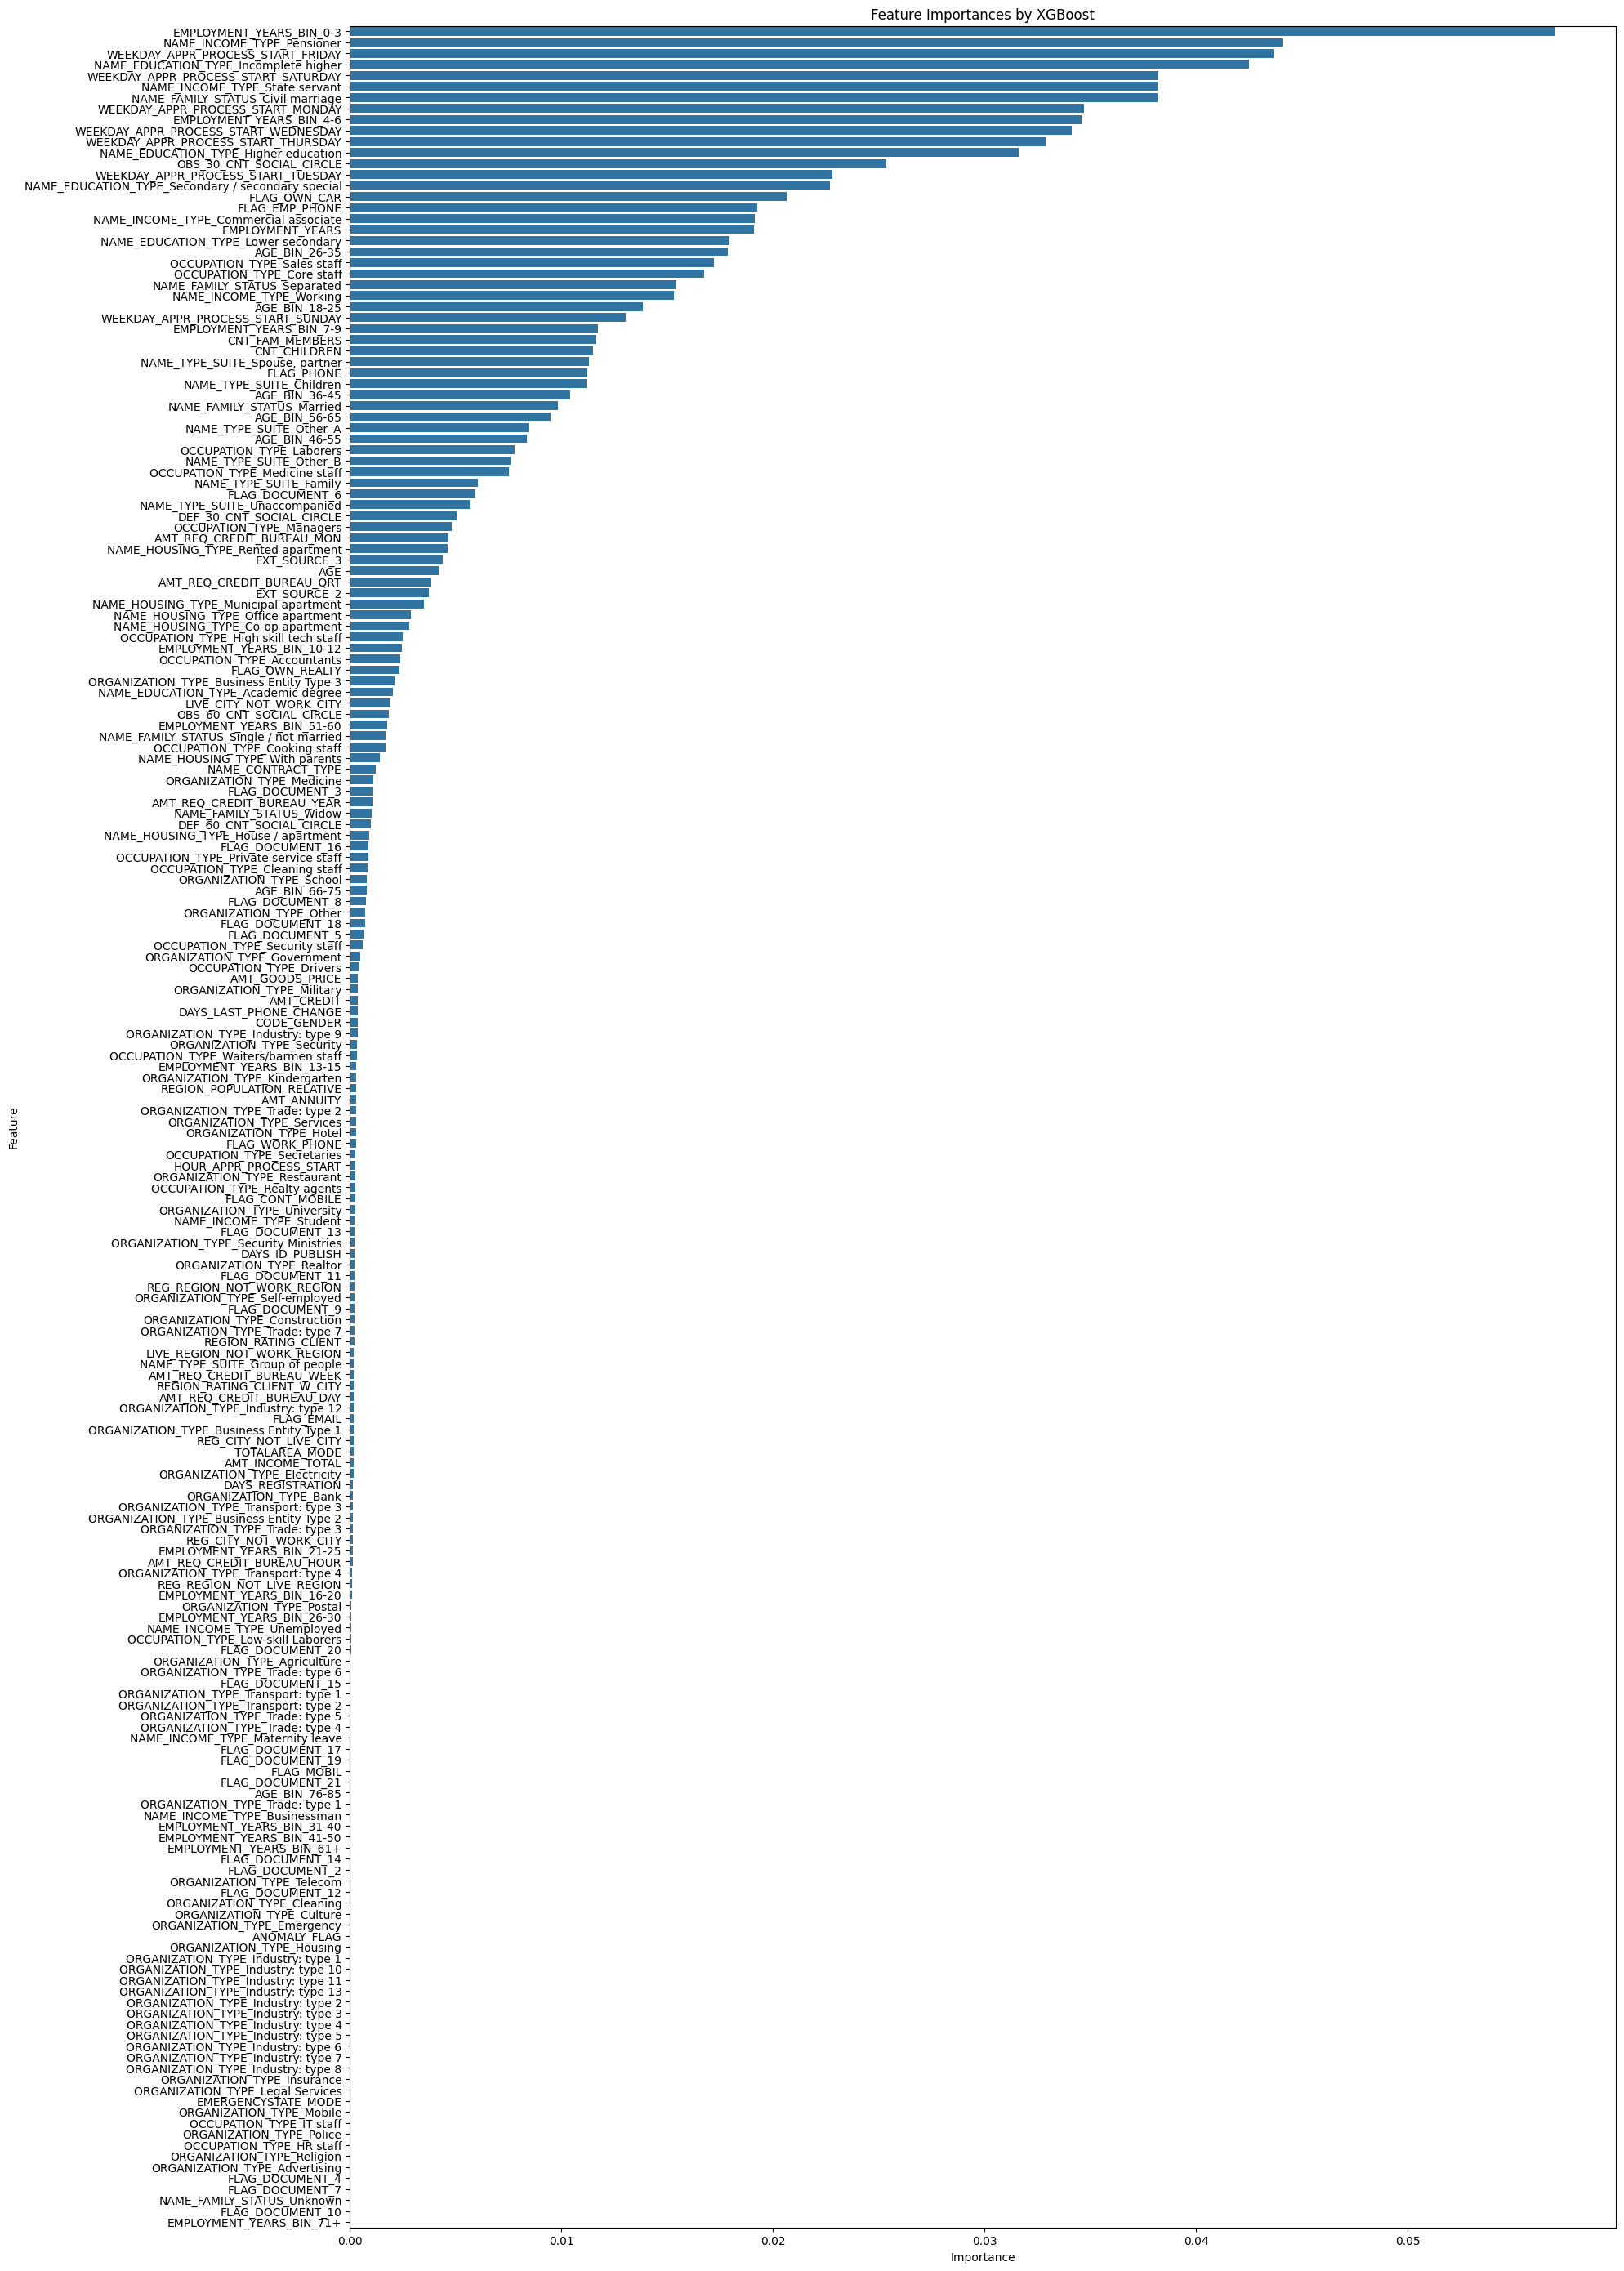

In [33]:
# Plot feature importances
plt.figure(figsize=(20, 35))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances by XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [34]:
# Set a threshold for feature importance
importance_threshold = 0.01

# Select features above the threshold
important_features = importance_df[importance_df['importance'] > importance_threshold]['feature'].tolist()

# Create a new dataset with only important features
X_important = pd.DataFrame(X, columns=X_df.columns)[important_features]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

In [36]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': xgb

}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print(f'{model_name} - Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}')

Logistic Regression - Train Accuracy: 0.95, Test Accuracy: 0.95
Random Forest - Train Accuracy: 0.97, Test Accuracy: 0.95
AdaBoost - Train Accuracy: 0.95, Test Accuracy: 0.95
XGBoost - Train Accuracy: 0.95, Test Accuracy: 0.96


        True Default  Predicted Probability of Default  Credit Score
74946              0                          0.080104    805.942993
312347             1                          0.999974    300.014343
380281             1                          0.999999    300.000793
374555             1                          0.999844    300.085632
150008             0                          0.070018    811.490356
Average Credit Score: 573.74
Default Rate: 50.20%


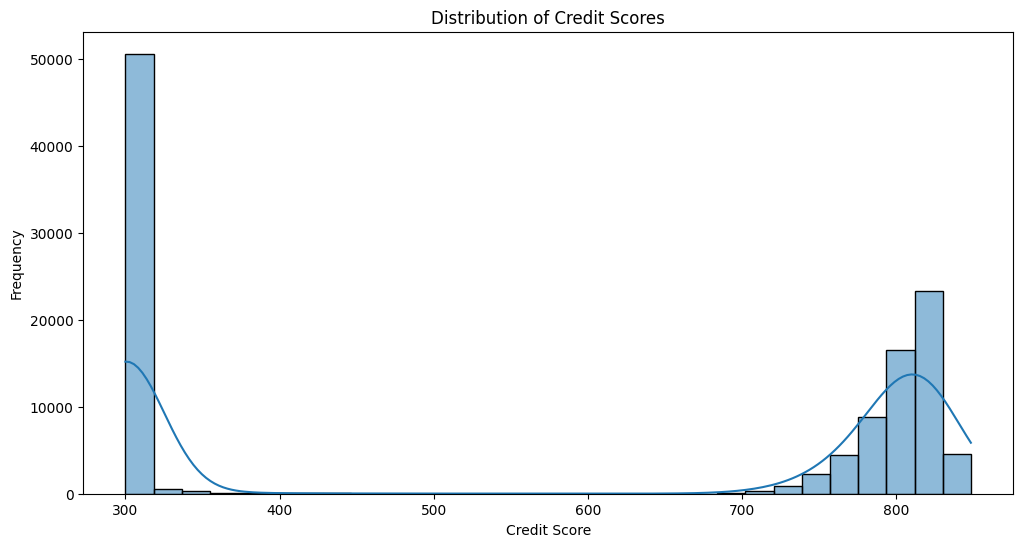

In [63]:
# Ensure X_test has the same columns as X_train
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Predict probabilities of default for the test set
y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # Probability of default (class 1)

max_score = 850  # Maximum credit score
min_score = 300   # Minimum credit score

# Calculate scaling factor
scaling_factor = max_score - min_score

# Calculate credit scores
credit_scores = max_score - (y_pred_proba * scaling_factor)

# Add credit scores to DataFrame for analysis
results_df = pd.DataFrame({
    'True Default': y_test,
    'Predicted Probability of Default': y_pred_proba,
    'Credit Score': credit_scores
})

print(results_df.head())

# Print the results for evaluation
print(f"Average Credit Score: {credit_scores.mean():.2f}")
print(f"Default Rate: {y_test.mean() * 100:.2f}%")

# Plot distribution of credit scores
plt.figure(figsize=(12, 6))
sns.histplot(credit_scores, bins=30, kde=True)
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

for model_name, model in models.items():
  y_pred = model.predict(X_test)

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f'{model_name} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}')
  print(f'Confusion Matrix:\n{conf_matrix}')

Logistic Regression - Precision: 1.00, Recall: 0.89, F1 Score: 0.94, ROC AUC: 0.95
Confusion Matrix:
[[56487    40]
 [ 6079 50902]]
Random Forest - Precision: 0.98, Recall: 0.91, F1 Score: 0.95, ROC AUC: 0.95
Confusion Matrix:
[[55526  1001]
 [ 5022 51959]]
AdaBoost - Precision: 0.99, Recall: 0.90, F1 Score: 0.94, ROC AUC: 0.95
Confusion Matrix:
[[55937   590]
 [ 5508 51473]]
XGBoost - Precision: 1.00, Recall: 0.91, F1 Score: 0.95, ROC AUC: 0.96
Confusion Matrix:
[[56508    19]
 [ 5064 51917]]
